In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("dataset.csv")
data.columns

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Depth Error',
       'Depth Seismic Stations', 'Magnitude', 'Magnitude Type',
       'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap',
       'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID',
       'Source', 'Location Source', 'Magnitude Source', 'Status'],
      dtype='object')

In [4]:
data = data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8


In [5]:
import datetime
import time

timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        # print('ValueError')
        timestamp.append('ValueError')
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values
final_data = data.drop(['Date', 'Time'], axis=1)
final_data = final_data[final_data.Timestamp != 'ValueError']
final_data.head()

,Latitude,Longitude,Depth,Magnitude,Timestamp
0,19.246,145.616,131.6,6.0,-157648542.0
1,1.863,127.352,80.0,5.8,-157483811.0
2,-20.579,-173.972,20.0,6.2,-157373642.0
3,-59.076,-23.557,15.0,5.8,-157111817.0
4,11.938,126.427,15.0,5.8,-157044430.0


/home/faizan/.local/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/faizan/.local/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


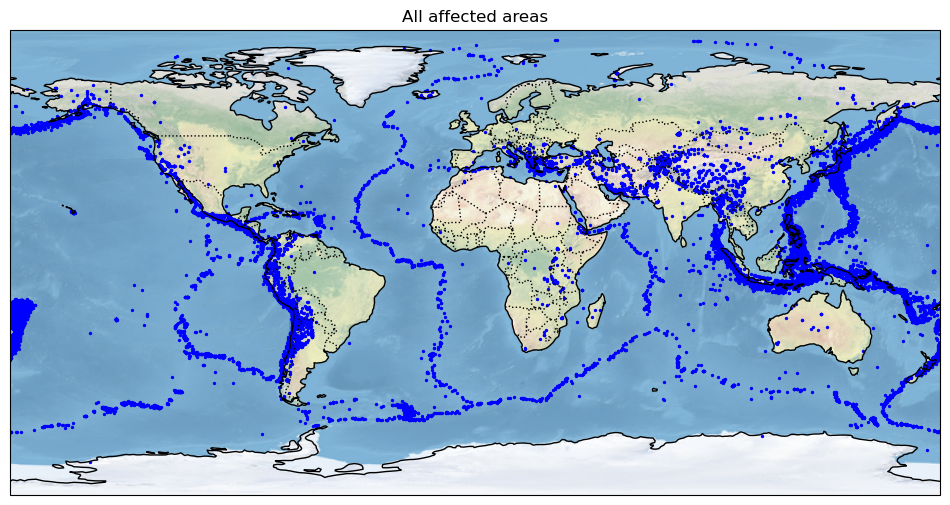

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set up the map projection (PlateCarree is similar to 'mill' projection in Basemap)
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot coastlines, countries, and add a background color
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.stock_img()  # Adds a nice background image
ax.set_global()

# Assuming 'data' is a pandas DataFrame with 'Longitude' and 'Latitude' columns
longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()

# Plot points on the map
plt.scatter(longitudes, latitudes, color='blue', s=2, transform=ccrs.PlateCarree())

# Title and show plot
plt.title("All affected areas")
plt.show()


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming 'final_data' is a pandas DataFrame
X = final_data[['Timestamp', 'Latitude', 'Longitude']]
y = final_data[['Magnitude', 'Depth']]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



(18727, 3) (4682, 3) (18727, 2) (4682, 2)
Latitude     0
Longitude    0
Depth        0
Magnitude    0
Timestamp    0
dtype: int64


#### Now I will create a neural network to fit the data from the training set. Our neural network will consist of three dense layers each with 16, 16, 2 nodes and reread. Relu and softmax will be used as activation functions:

In [26]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(neurons, activation, optimizer, loss='mean_squared_error'):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='linear'))  # Change activation to linear
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])  # Use mean absolute error as a metric
    
    return model


#### Now I’m going to define the hyperparameters with two or more options to find the best fit:

In [28]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X_train, y_train are defined
X = final_data[['Timestamp', 'Latitude', 'Longitude']]
y = final_data[['Magnitude', 'Depth']]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_model(neurons=16, activation='relu', optimizer='SGD', loss='mean_squared_error'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(tf.keras.layers.Dense(neurons, activation=activation))
    model.add(tf.keras.layers.Dense(2, activation='linear'))  # Output layer with 2 units
    
    # Adjust learning rate for optimizers
    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=0.001)  # Smaller learning rate
    elif optimizer == 'Adadelta':
        opt = tf.keras.optimizers.Adadelta(learning_rate=0.001)
    
    model.compile(optimizer=opt, loss=loss, metrics=['mean_squared_error'])
    
    return model

# Hyperparameter grid
neurons = [16]
batch_size = [10]
epochs = [10]
activation = ['sigmoid', 'relu']
optimizer = ['SGD', 'Adadelta']
loss = ['mean_squared_error']  # Use a suitable loss function for regression

results = []

for n in neurons:
    for bs in batch_size:
        for ep in epochs:
            for act in activation:
                for opt in optimizer:
                    for los in loss:
                        model = create_model(neurons=n, activation=act, optimizer=opt, loss=los)
                        history = model.fit(X_train_scaled, y_train, epochs=ep, batch_size=bs, verbose=0)
                        score = model.evaluate(X_train_scaled, y_train, verbose=0)
                        results.append((score[0], {'neurons': n, 'batch_size': bs, 'epochs': ep, 'activation': act, 'optimizer': opt, 'loss': los}))

# Print the training loss for monitoring
print(history.history['loss'])

mean_scores = []
params_list = []

for result in results:
    mean_scores.append(result[0])
    params_list.append(result[1])

# Find the best result
best_index = np.argmax(mean_scores)
best_score = mean_scores[best_index]
best_params = params_list[best_index]

# Print the best result
print(f"Best: {best_score} using {best_params}")

# Print all results
for mean, param in zip(mean_scores, params_list):
    print("%f with: %r" % (mean, param))


/home/faizan/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/faizan/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/faizan/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_reg

[10037.0791015625, 10035.775390625, 10034.49609375, 10033.2099609375, 10031.896484375, 10030.6416015625, 10029.3779296875, 10028.14453125, 10026.923828125, 10025.6865234375]
Best: 10025.0625 using {'neurons': 16, 'batch_size': 10, 'epochs': 10, 'activation': 'relu', 'optimizer': 'Adadelta', 'loss': 'mean_squared_error'}
6716.203125 with: {'neurons': 16, 'batch_size': 10, 'epochs': 10, 'activation': 'sigmoid', 'optimizer': 'SGD', 'loss': 'mean_squared_error'}
9952.395508 with: {'neurons': 16, 'batch_size': 10, 'epochs': 10, 'activation': 'sigmoid', 'optimizer': 'Adadelta', 'loss': 'mean_squared_error'}
7502.625488 with: {'neurons': 16, 'batch_size': 10, 'epochs': 10, 'activation': 'relu', 'optimizer': 'SGD', 'loss': 'mean_squared_error'}
10025.062500 with: {'neurons': 16, 'batch_size': 10, 'epochs': 10, 'activation': 'relu', 'optimizer': 'Adadelta', 'loss': 'mean_squared_error'}


In the step below, the best-fit parameters are used for the same model to calculate the score with the training data and the test data:

In [29]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(3,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', loss='squared_hinge', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1, validation_data=(X_test, y_test))

[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

Epoch 1/20


/home/faizan/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1873/1873 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0816 - loss: 0.5000 - val_accuracy: 0.0758 - val_loss: 0.5000
Epoch 2/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0804 - loss: 0.5000 - val_accuracy: 0.0758 - val_loss: 0.5000
Epoch 3/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0823 - loss: 0.5000 - val_accuracy: 0.0758 - val_loss: 0.5000
Epoch 4/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0811 - loss: 0.5000 - val_accuracy: 0.0758 - val_loss: 0.5000
Epoch 5/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0807 - loss: 0.5000 - val_accuracy: 0.0758 - val_loss: 0.5000
Epoch 6/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0811 - loss: 0.5000 - val_accuracy: 0.0758 - val_loss: 0.5000
Epoch 7/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0821 - loss: 0.5000 - val_accuracy: 0.0758 - val_loss: 0.5000
Epoch 8/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0878 - loss: 0.5000 - val_accurac